In [1]:
import numpy as np
import numpy
from nbodykit.lab import BigFileMesh, BigFileCatalog
from pmesh.pm import ParticleMesh
import os, sys
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

from nbodykit.cosmology import Cosmology, EHPower, Planck15

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/dask/context.py:23: UserWarning: The dask.set_options function has been deprecated. Please use dask.config.set instead
  warnings.warn("The dask.set_options function has been deprecated. "


In [2]:
import tensorflow as tf
# tf.enable_eager_execution()

In [3]:
sys.path.append('../code/utils/')
import tools
from background import *
# sys.path.append('/global/homes/c/chmodi/Programs/cosmo4d/train_nets-tflow/')
# import tools 

# sys.path.append('/global/homes/c/chmodi/Programs/cosmo4d/train_nets/')
# import features as ft



In [4]:
# bs = 16
# nc = 4
# step = 5
# pm = ParticleMesh(BoxSize=bs, Nmesh = [nc, nc, nc], dtype='f4')

# nparticle = 2
# pos = bs*np.random.random(3*nparticle).reshape(-1, 3).astype(np.float32)

# mesh = pm.paint(pos)



# Paint and readout

In [5]:

def cic_paint(mesh, part, weight=None, cube_size=None):
    """
        - mesh is a cube
        - part is a list of particles (:, 3), positions in mesh units
        - weight is a list of weights (:)
        - cube_size is the size of the cube in mesh units
    """

    # Create a variable to store the input mesh
    var = tf.Variable(0, dtype=tf.float32)
    var = tf.assign(var, mesh, validate_shape=False)
#     var = mesh
    if weight is None: weight = np.ones(part.shape[0], dtype=part.dtype)
    if cube_size is None: cube_size = mesh.shape[0].value
    
    # Extract the indices of all the mesh points affected by each particles
    i000 = tf.cast(tf.floor(part), dtype=tf.int32)
    i100 = i000 + tf.constant([1, 0, 0])
    i010 = i000 + tf.constant([0, 1, 0])
    i001 = i000 + tf.constant([0, 0, 1])
    i110 = i000 + tf.constant([1, 1, 0])
    i101 = i000 + tf.constant([1, 0, 1])
    i011 = i000 + tf.constant([0, 1, 1])
    i111 = i000 + tf.constant([1, 1, 1])
    neighboor_coords = tf.stack([i000, i100, i010, i001,
                                 i110, i101, i011, i111], axis=1)
    kernel = 1. - tf.abs(tf.expand_dims(part, axis=1) - tf.cast(neighboor_coords, tf.float32))
    kernel = tf.reduce_prod(kernel, axis=-1, keepdims=False)
    kernel = tf.expand_dims(weight, axis=1) * kernel
        
#     if cube_size is not None:
    neighboor_coords = neighboor_coords % cube_size

    updated_mesh = tf.scatter_nd_add(var, tf.reshape(neighboor_coords, (-1, 3)),
                                     tf.reshape(kernel, (-1,)))
    return updated_mesh




def cic_readout(mesh, part, cube_size=None):
    """
        - mesh is a cube
        - part is a list of particles (:, 3), positions in mesh units
        - cube_size is the size of the cube in mesh units
    """

    if cube_size is None: cube_size = mesh.shape[0].value
    # Extract the indices of all the mesh points affected by each particles
    i000 = tf.cast(tf.floor(part), dtype=tf.int32)
    i100 = i000 + tf.constant([1, 0, 0])
    i010 = i000 + tf.constant([0, 1, 0])
    i001 = i000 + tf.constant([0, 0, 1])
    i110 = i000 + tf.constant([1, 1, 0])
    i101 = i000 + tf.constant([1, 0, 1])
    i011 = i000 + tf.constant([0, 1, 1])
    i111 = i000 + tf.constant([1, 1, 1])
    neighboor_coords = tf.stack([i000, i100, i010, i001,
                                 i110, i101, i011, i111], axis=1)
    kernel = 1. - tf.abs(tf.expand_dims(part, axis=1) - tf.cast(neighboor_coords, tf.float32))
    kernel = tf.reduce_prod(kernel, axis=-1, keepdims=False)
    
#     if cube_size is not None:
    neighboor_coords = neighboor_coords % cube_size

    meshvals = tf.gather_nd(mesh, neighboor_coords)
    weightedvals = tf.multiply(meshvals, kernel)
    value = tf.reduce_sum(weightedvals, axis=1)
    return value


def checkpaint():
    bs = 50
    nc = 16
    pm = ParticleMesh(BoxSize=bs, Nmesh = [nc, nc, nc], dtype='f4')
    nparticle = 100
    pos = bs*np.random.random(3*nparticle).reshape(-1, 3).astype(np.float32)
    wts = np.random.random(nparticle).astype(np.float32)
    
    pmmesh = pm.paint(pos, mass=wts)
    
    tfmesh = tf.zeros((nc, nc, nc), dtype=tf.float32)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        tfmesh = sess.run(cic_paint(tfmesh, pos*nc/bs, weight=wts))
    
    print(abs(pmmesh[...] - tfmesh).sum())


def checkreadout():
    bs = 50
    nc = 16
    pm = ParticleMesh(BoxSize=bs, Nmesh = [nc, nc, nc], dtype='f4')
    nparticle = 100
    pos = bs*np.random.random(3*nparticle).reshape(-1, 3).astype(np.float32)
    base = 100*np.random.random(nc**3).reshape(nc, nc, nc).astype(np.float32)
    
    pmmesh = pm.create(mode='real', value=base)    
    pmread = pmmesh.readout(pos)
    
    tfmesh = tf.constant(base, dtype=tf.float32)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        tfread = sess.run(cic_readout(tfmesh, pos*nc/bs))
    
    print(abs((pmread[...] - tfread)/pmread).sum())
#     print(abs(pmread[...] - tfread).sum()

In [6]:
checkpaint()
checkreadout()

3.0986565e-05
1.820787589099032e-05


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel/__main__.py:99: DeprecationWarning: argument mode is deprecated. use type=real instead


# LPT

In [7]:
def laplace(k, v):
    kk = sum(ki ** 2 for ki in k)
    mask = (kk == 0).nonzero()
    kk[mask] = 1
    b = v / kk
    b[mask] = 0
    return b

def gradient(dir, order=1):
    if order == 0:
        def kernel(k, v):
            # clear the nyquist to ensure field is real
            mask = v.i[dir] != v.Nmesh[dir] // 2
            return v * (1j * k[dir]) * mask
    if order == 1:
        def kernel(k, v):
            cellsize = (v.BoxSize[dir] / v.Nmesh[dir])
            w = k[dir] * cellsize

            a = 1 / (6.0 * cellsize) * (8 * numpy.sin(w) - numpy.sin(2 * w))
            # a is already zero at the nyquist to ensure field is real
            return v * (1j * a)
    return kernel


def lpt1(dlin_k, q, resampler='cic'):
    """ Run first order LPT on linear density field, returns displacements of particles
        reading out at q. The result has the same dtype as q.
    """
    basepm = dlin_k.pm
        
    ndim = len(basepm.Nmesh)
    delta_k = basepm.create('complex', value=1)

    
    layout = basepm.decompose(q)
    local_q = layout.exchange(q)

    source = numpy.zeros((len(q), ndim), dtype=q.dtype)
    toret = []
    for d in range(len(basepm.Nmesh)):
        disp = dlin_k.apply(laplace) \
                    .apply(gradient(d), out=Ellipsis) \
                    .c2r(out=Ellipsis)
#         toret.append(dlin_k.apply(laplace).apply(gradient(d), out=Ellipsis))
        toret.append(disp)

        local_disp = disp.readout(local_q, resampler=resampler)
        source[..., d] = layout.gather(local_disp)
#     return toret
    return source




# def tflaplace(v, gdict):
#     kvec = gdict['kvec']
#     kk = sum(ki**2 for ki in kvec)
#     mask = (kk == 0).nonzero()
#     kk[mask] = 1
#     imask = (~(kk==0)).astype(int)
#     b = tf.multiply(v, 1/kk)
#     b = tf.multiply(b, imask)
#     return b 


# def tfgradient(v, dir, gdict):
#     kvec = gdict['kvec']
#     bs, nc = gdict['bs'], gdict['nc']
#     cellsize = bs/nc
#     w = kvec[dir] * cellsize
#     a = 1 / (6.0 * cellsize) * (8 * numpy.sin(w) - numpy.sin(2 * w))
#     ac = a*1j
#     # a is already zero at the nyquist to ensure field is real
#     return tf.multiply(v , ac)
    

# def tflpt1(dlin_k, pos, gdict):
#     """ Run first order LPT on linear density field, returns displacements of particles
#         reading out at q. The result has the same dtype as q.
#     """
#     bs, nc = gdict['bs'], gdict['nc']        
# #     kvec = tools.fftk((nc, nc, nc), bs)
# #     gdict['kvec'] = kvec
    
#     ones = tf.ones_like(dlin_k)
#     lap = tflaplace(ones, gdict)
    
#     displacement = tf.zeros_like(pos)
#     displacement = []
#     for d in range(3):
#         kweight = tf.multiply(tfgradient(ones, d, gdict), lap)
#         dispc = tf.multiply(kweight, dlin_k)
#         disp = tf.multiply(tf.spectral.irfft3d(dispc), nc**3)
#         displacement.append(cic_readout(disp, pos))

#     return tf.stack(displacement, axis=1)



def tflaplace(gdict):
    kvec = gdict['kvec']
    kk = sum(ki**2 for ki in kvec)
    mask = (kk == 0).nonzero()
    kk[mask] = 1
    wts = 1/kk
    imask = (~(kk==0)).astype(int)
    wts *= imask
    return wts
#     b = tf.multiply(v, 1/kk)
#     b = tf.multiply(b, imask)
#     return b 


def tfgradient(gdict, dir):
    kvec = gdict['kvec']
    bs, nc = gdict['bs'], gdict['nc']
    cellsize = bs/nc
    w = kvec[dir] * cellsize
    a = 1 / (6.0 * cellsize) * (8 * numpy.sin(w) - numpy.sin(2 * w))
    wts = a*1j
    return wts
    # a is already zero at the nyquist to ensure field is real
#     return tf.multiply(v , ac)
    

def tflpt1(dlin_k, pos, gdict):
    """ Run first order LPT on linear density field, returns displacements of particles
        reading out at q. The result has the same dtype as q.
    """
    bs, nc = gdict['bs'], gdict['nc']        
#     kvec = tools.fftk((nc, nc, nc), bs)
#     gdict['kvec'] = kvec
    
#     ones = tf.ones_like(dlin_k)
    lap = tflaplace(gdict)
    
    displacement = tf.zeros_like(pos)
    displacement = []
    for d in range(3):
#         kweight = tf.multiply(tfgradient(d, gdict), lap)
        kweight = tfgradient(gdict, d)* lap
        dispc = tf.multiply(kweight, dlin_k)
        disp = tf.multiply(tf.spectral.irfft3d(dispc), nc**3)
        displacement.append(cic_readout(disp, pos))

    return tf.stack(displacement, axis=1)


In [35]:
bs = 16
nc = 4
pm = ParticleMesh(BoxSize=bs, Nmesh = [nc, nc, nc], dtype='f4')
kvec = tools.fftk((nc, nc, nc), bs, dtype=np.float32)
gdict = {'bs':bs, 'nc':nc, 'kvec':kvec}
nparticle = 2
pos = bs*np.random.random(3*nparticle).reshape(-1, 3).astype(np.float32)

white = pm.generate_whitenoise(100, mode='real')
whitec = white.r2c()
#
tmp = lpt1(whitec, pos)



/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel/__main__.py:9: DeprecationWarning: mode argument is deprecated, use type


In [36]:
# #Check here in lazy mode

#
# twhite = tf.constant(white[...])
# twhitec = tf.spectral.rfft3d(twhite)/tf.reduce_prod(twhite.shape).numpy()
# ttmp = tflpt1(twhitec, pos*nc/bs, gdict)

# print(tmp, ttmp.numpy())

# # ii = 1
# # jj = 2
# # for jj in [0, 1, 2]:
# # #     print(tmp[ii][jj].real/ ttmp.numpy()[ii][jj].real)
# #     print(tmp[ii][jj].imag - ttmp.numpy()[ii][jj].imag)

In [37]:
##Check here in sess run mode 

#
twhite = tf.constant(white[...])
twhitec = tf.multiply(tf.spectral.rfft3d(twhite), 1/nc**3)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ttmp = sess.run(tflpt1(twhitec, pos*nc/bs, gdict))

print(tmp)
print(ttmp)
print(tmp/ttmp)


[[-4.0073514 -0.8618942  7.2352996]
 [-3.9987152 -1.88209    6.474425 ]]
[[-4.0073514 -0.8618947  7.2353   ]
 [-3.9987156 -1.8820901  6.4744253]]
[[1.         0.9999994  0.99999994]
 [0.9999999  0.99999994 0.99999994]]


## lpt 2

In [11]:

def lpt2source(dlin_k):
    """ Generate the second order LPT source term.  """
    source = dlin_k.pm.create('real')
    source[...] = 0
    if dlin_k.ndim != 3: # only for 3d
        return source.r2c(out=Ellipsis)

    D1 = [1, 2, 0]
    D2 = [2, 0, 1]

    phi_ii = []

    # diagnoal terms
    for d in range(dlin_k.ndim):
        phi_ii_d = dlin_k.apply(laplace) \
                     .apply(gradient(d), out=Ellipsis) \
                     .apply(gradient(d), out=Ellipsis) \
                     .c2r(out=Ellipsis)
        phi_ii.append(phi_ii_d)

    for d in range(3):
        source[...] += phi_ii[D1[d]].value * phi_ii[D2[d]].value

#     return source

    # free memory
    phi_ii = []

    phi_ij = []
    # off-diag terms
    for d in range(dlin_k.ndim):
        phi_ij_d = dlin_k.apply(laplace) \
                 .apply(gradient(D1[d]), out=Ellipsis) \
                 .apply(gradient(D2[d]), out=Ellipsis) \
                 .c2r(out=Ellipsis)

        source[...] -= phi_ij_d[...] ** 2

    # this ensures x = x0 + dx1(t) + d2(t) for 2LPT

    source[...] *= 3.0 / 7
#     return source
    return source.r2c(out=Ellipsis)




# def tflpt2source(dlin_k, gdict):
#     """ Generate the second order LPT source term.  """

#     bs, nc = gdict['bs'], gdict['nc']
#     source = tf.zeros((nc, nc, nc))
#     ones = tf.ones_like(dlin_k)
    
#     D1 = [1, 2, 0]
#     D2 = [2, 0, 1]

#     phi_ii = []

#     # diagnoal terms
#     lap = tflaplace(ones, gdict)
    
#     for d in range(3):
#         grad = tfgradient(ones, d, gdict)
#         kweight = tf.multiply(grad, grad)
#         kweight = tf.multiply(kweight, lap)
#         phic = tf.multiply(kweight, dlin_k)
#         phi_ii.append(tf.multiply(tf.spectral.irfft3d(phic), nc**3))


#     for d in range(3):
#         source = tf.add(source, tf.multiply(phi_ii[D1[d]], phi_ii[D2[d]]))
    
# #     return source
#     # free memory
#     phi_ii = []

#     # off-diag terms
#     for d in range(3):
#         gradi = tfgradient(ones, D1[d], gdict)
#         gradj = tfgradient(ones, D2[d], gdict)
#         kweight = tf.multiply(gradi, gradj)
#         kweight = tf.multiply(kweight, lap)
#         phic = tf.multiply(kweight, dlin_k)
#         phi = tf.multiply(tf.spectral.irfft3d(phic), nc**3)
#         source = tf.subtract(source, tf.multiply(phi, phi))

#     source = tf.multiply(source, 3.0/7.)
# #     return source
#     return tf.multiply(tf.spectral.rfft3d(source), 1/nc**3)



def tflpt2source(dlin_k, gdict):
    """ Generate the second order LPT source term.  """

    bs, nc = gdict['bs'], gdict['nc']
    source = tf.zeros((nc, nc, nc))
#     ones = tf.ones_like(dlin_k)
    
    D1 = [1, 2, 0]
    D2 = [2, 0, 1]

    phi_ii = []

    # diagnoal terms
    lap = tflaplace(gdict)
    
    for d in range(3):
        grad = tfgradient(gdict, d)
#         kweight = tf.multiply(grad, grad)
#         kweight = tf.multiply(kweight, lap)
        kweight = grad*grad*lap
        phic = tf.multiply(kweight, dlin_k)
        phi_ii.append(tf.multiply(tf.spectral.irfft3d(phic), nc**3))


    for d in range(3):
        source = tf.add(source, tf.multiply(phi_ii[D1[d]], phi_ii[D2[d]]))
    
#     return source
    # free memory
    phi_ii = []

    # off-diag terms
    for d in range(3):
        gradi = tfgradient(gdict, D1[d])
        gradj = tfgradient(gdict, D2[d])
#         kweight = tf.multiply(gradi, gradj)
#         kweight = tf.multiply(kweight, lap)
        kweight = gradi*gradj*lap
        phic = tf.multiply(kweight, dlin_k)
        phi = tf.multiply(tf.spectral.irfft3d(phic), nc**3)
        source = tf.subtract(source, tf.multiply(phi, phi))

    source = tf.multiply(source, 3.0/7.)
#     return source
    return tf.multiply(tf.spectral.rfft3d(source), 1/nc**3)




In [12]:
bs = 16
nc = 4
pm = ParticleMesh(BoxSize=bs, Nmesh = [nc, nc, nc], dtype='f4')
kvec = tools.fftk((nc, nc, nc), bs, dtype=np.float32)
gdict = {'bs':bs, 'nc':nc, 'kvec':kvec}
nparticle = 2
pos = bs*np.random.random(3*nparticle).reshape(-1, 3).astype(np.float32)

#
white = pm.generate_whitenoise(100, mode='real')
whitec = white.r2c()
tmp = lpt2source(whitec)



/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel/__main__.py:10: DeprecationWarning: mode argument is deprecated, use type


In [13]:
# #Check here in lazy mode
# twhite = tf.constant(white[...])
# twhitec = tf.spectral.rfft3d(twhite)/tf.reduce_prod(twhite.shape).numpy()
# ttmp = tflpt2source(twhitec, gdict)

# ii = 1
# jj = 2
# for jj in [0, 1, 2]:
#     print(tmp[ii][jj].real/ ttmp.numpy()[ii][jj].real)
#     print(tmp[ii][jj].imag / ttmp.numpy()[ii][jj].imag)

In [14]:
# Check here in sess run mode
twhite = tf.constant(white[...])
twhitec = tf.multiply(tf.spectral.rfft3d(twhite), 1/nc**3)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ttmp = sess.run(tflpt2source(twhitec, gdict))

ii = 1
jj = 2
for jj in [0, 1, 2]:
    print(tmp[ii][jj].real/ ttmp[ii][jj].real)
    print(tmp[ii][jj].imag / ttmp[ii][jj].imag)

[0.99999994 0.99999994 1.0000002 ]
[1.         0.99999994 1.0000018 ]
[0.9999997 0.9999999 1.0000014]
[0.9999998 1.0000058 1.       ]
[1.        1.0000001 1.0000002]
[0.9999996  0.99999994 0.9999996 ]


## lpt 2nd order


In [42]:
def lpt( lineark, Q, a=1, order=2):
    """ This computes the 'force' from LPT as well. """

#     state = StateVector(self, Q)
#     pt = PerturbationGrowth(self.cosmology, a=[a], a_normalize=self.a_linear)
#     DX1 = pt.D1(a) * lpt1(lineark, Q)
    DX1 = 1 * lpt1(lineark, Q)

#     V1 = a ** 2 * pt.f1(a) * pt.E(a) * DX1
    if order == 2:
        DX2 = 1 * lpt1(lpt2source(lineark), Q)
#         DX2 = pt.D2(a) * lpt1(lpt2source(linear), Q)
#         V2 = a ** 2 * pt.f2(a) * pt.E(a) * DX2
#         state.S[...] = DX1 + DX2
#         state.P[...] = V1 + V2
#         state.F[...] = a ** 2 * pt.E(a) * (pt.gf(a) / pt.D1(a) * DX1 + pt.gf2(a) / pt.D2(a) * DX2)
    else:
        DX2 = 0
#         state.S[...] = DX1
#         state.P[...] = V1
#         state.F[...] = a ** 2 * pt.E(a) * (pt.gf(a) / pt.D1(a) * DX1)

#     return state
    return DX1 + DX2


def tflpt(lineark, Q, gdict, a=1, order=2):
    
    bs, nc = gdict['bs'], gdict['nc']
    pos = Q*nc/bs
    
    DX1 = 1 * tflpt1(lineark, pos, gdict)
    DX2 = 1 * tflpt1(tflpt2source(lineark, gdict), pos, gdict)
    return tf.add(DX1 , DX2)
    

In [43]:
bs = 16
nc = 4
pm = ParticleMesh(BoxSize=bs, Nmesh = [nc, nc, nc], dtype='f4')
kvec = tools.fftk((nc, nc, nc), bs, dtype=np.float32)
gdict = {'bs':bs, 'nc':nc, 'kvec':kvec}
nparticle = 2
pos = bs*np.random.random(3*nparticle).reshape(-1, 3).astype(np.float32)
#
white = pm.generate_whitenoise(100, mode='real')
whitec = white.r2c()
tmp = lpt(whitec, pos)
#




/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel/__main__.py:9: DeprecationWarning: mode argument is deprecated, use type


In [44]:
# # Check here in lazy mode

# twhite = tf.constant(white[...])
# twhitec = tf.spectral.rfft3d(twhite)/tf.reduce_prod(twhite.shape).numpy()
# ttmp = tflpt(twhitec, pos, gdict)

# print(tmp, ttmp.numpy())


In [45]:
# Check here in sess run mode
twhite = tf.constant(white[...])
twhitec = tf.multiply(tf.spectral.rfft3d(twhite), 1/nc**3)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ttmp = sess.run(tflpt(twhitec, pos, gdict))

print(tmp)
print(ttmp)
print(tmp/ttmp)

# ii = 1
# jj = 2
# for jj in [0, 1, 2]:
#     print(tmp[ii][jj].real/ ttmp[ii][jj].real)
#     print(tmp[ii][jj].imag / ttmp[ii][jj].imag)

[[-0.42570466  0.57818663 -1.226293  ]
 [ 1.9751954   2.6905503   5.7782583 ]]
[[-0.42570466  0.57818687 -1.2262927 ]
 [ 1.9751954   2.6905499   5.7782574 ]]
[[1.        0.9999996 1.0000002]
 [1.        1.0000001 1.0000001]]


## lpt figure

In [19]:
bs = 100
nc = 32
pm = ParticleMesh(BoxSize=bs, Nmesh = [nc, nc, nc], dtype='f4')
grid = pm.generate_uniform_particle_grid(shift=0).astype(np.float32)
kvec = tools.fftk((nc, nc, nc), bs, dtype=np.float32)
gdict = {'bs':bs, 'nc':nc, 'kvec':kvec}




In [20]:
whitec = pm.generate_whitenoise(100, mode='complex', unitary=False)
lineark = whitec.apply(lambda k, v:Planck15.get_pklin(sum(ki ** 2 for ki in k)**0.5, 0) ** 0.5 * v / v.BoxSize.prod() ** 0.5)
linear = lineark.c2r()

lptdisp = lpt(lineark, grid, order=2)
lptpos = grid + lptdisp
lptmesh =  pm.paint(lptpos)


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: mode argument is deprecated, use type
  if __name__ == '__main__':


In [21]:
# #
tlinear = tf.constant(linear[...])
tlineark = tf.multiply(tf.spectral.rfft3d(tlinear), 1/nc**3)
tlptmesh = tf.zeros_like(tlinear)
# wt = tf.ones(nc**3)
wt = np.ones(nc**3, dtype=np.float32)
tlptdisp = tflpt(tlineark, grid, gdict)
tlptpos = tf.add(grid, tlptdisp)
tlptmesh = cic_paint(tlptmesh, tf.multiply(tlptpos, nc/bs), weight=wt)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tflptpos, tflptmesh = sess.run([tlptpos, tlptmesh])

In [22]:
tflptpos/lptpos

array([[1.000002  , 1.0000001 , 0.9999995 ],
       [1.0000018 , 1.        , 0.99999976],
       [1.0000005 , 0.99999946, 0.99999994],
       ...,
       [1.        , 1.        , 1.0000001 ],
       [1.        , 1.        , 1.0000001 ],
       [1.        , 1.        , 1.        ]], dtype=float32)

Text(0.5,1,'Yu 2LPT')

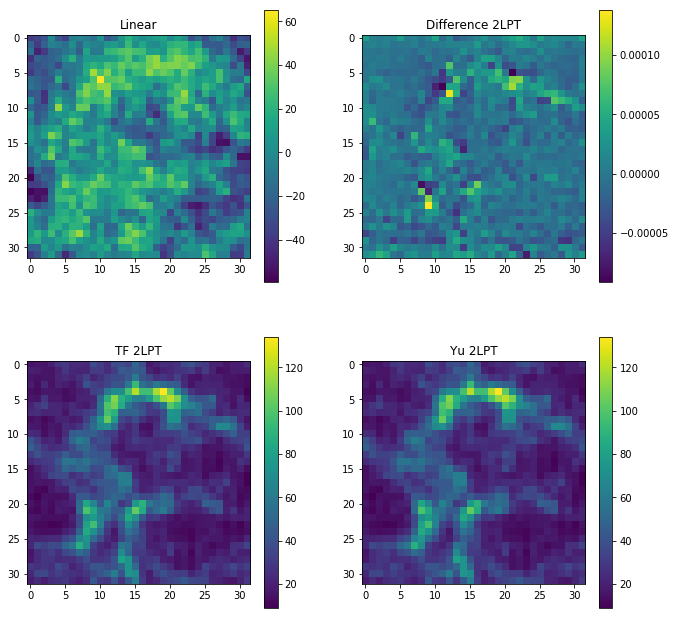

In [23]:
fig, axar = plt.subplots(2, 2, figsize = (11, 11))
ax = axar[0]
im = ax[0].imshow(linear[...].sum(axis=0))
plt.colorbar(im, ax=ax[0])
ax[0].set_title('Linear')
im = ax[1].imshow((lptmesh-tflptmesh)[...].sum(axis=0))
plt.colorbar(im, ax=ax[1])
ax[1].set_title('Difference 2LPT')
ax = axar[1]
im = ax[0].imshow(tflptmesh[...].sum(axis=0))
plt.colorbar(im, ax=ax[0])
ax[0].set_title('TF 2LPT')
im = ax[1].imshow(lptmesh[...].sum(axis=0))
plt.colorbar(im, ax=ax[1])
ax[1].set_title('Yu 2LPT')



# FastPM

In [48]:
bs = 100
nc = 32
pm = ParticleMesh(BoxSize=bs, Nmesh = [nc, nc, nc], dtype='f4')
grid = pm.generate_uniform_particle_grid(shift=0).astype(np.float32)
kvec = tools.fftk((nc, nc, nc), bs, dtype=np.float32)
gdict = {'bs':bs, 'nc':nc, 'kvec':kvec}

whitec = pm.generate_whitenoise(100, mode='complex', unitary=False)
lineark = whitec.apply(lambda k, v:Planck15.get_pklin(sum(ki ** 2 for ki in k)**0.5, 0) ** 0.5 * v / v.BoxSize.prod() ** 0.5)
linear = lineark.c2r()

lptdisp = lpt(lineark, grid, order=2)
lptpos = grid + lptdisp
lptmesh =  pm.paint(lptpos)



/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel/__main__.py:8: DeprecationWarning: mode argument is deprecated, use type


In [49]:
#Verified LPT CODE
#######################################################################

def lpt1(dlin_k, q, resampler='cic'):
    """ Run first order LPT on linear density field, returns displacements of particles
        reading out at q. The result has the same dtype as q.
    """
    basepm = dlin_k.pm

    ndim = len(basepm.Nmesh)
    delta_k = basepm.create('complex')

    layout = basepm.decompose(q)
    local_q = layout.exchange(q)

    source = numpy.zeros((len(q), ndim), dtype=q.dtype)
    for d in range(len(basepm.Nmesh)):
        disp = dlin_k.apply(laplace) \
                    .apply(gradient(d), out=Ellipsis) \
                    .c2r(out=Ellipsis)
        local_disp = disp.readout(local_q, resampler=resampler)
        source[..., d] = layout.gather(local_disp)
    return source

def lpt2source(dlin_k):
    """ Generate the second order LPT source term.  """
    source = dlin_k.pm.create('real')
    source[...] = 0
    if dlin_k.ndim != 3: # only for 3d
        return source.r2c(out=Ellipsis)

    D1 = [1, 2, 0]
    D2 = [2, 0, 1]

    phi_ii = []

    # diagnoal terms
    for d in range(dlin_k.ndim):
        phi_ii_d = dlin_k.apply(laplace) \
                     .apply(gradient(d), out=Ellipsis) \
                     .apply(gradient(d), out=Ellipsis) \
                     .c2r(out=Ellipsis)
        phi_ii.append(phi_ii_d)

    for d in range(3):
        source[...] += phi_ii[D1[d]].value * phi_ii[D2[d]].value

    # free memory
    phi_ii = []

    phi_ij = []
    # off-diag terms
    for d in range(dlin_k.ndim):
        phi_ij_d = dlin_k.apply(laplace) \
                 .apply(gradient(D1[d]), out=Ellipsis) \
                 .apply(gradient(D2[d]), out=Ellipsis) \
                 .c2r(out=Ellipsis)

        source[...] -= phi_ij_d[...] ** 2

    # this ensures x = x0 + dx1(t) + d2(t) for 2LPT

    source[...] *= 3.0 / 7
    return source.r2c(out=Ellipsis)

#######################################################################



### longrange force

In [104]:

def fknlongrange(r_split):
    if r_split != 0:
        def kernel(k, v):
            kk = sum(ki ** 2 for ki in k)
            return v * numpy.exp(-kk * r_split**2)
    else:
        def kernel(k, v):
            return v
    return kernel


def longrange(x, delta_k, split, factor):
    """ factor shall be 3 * Omega_M / 2, if delta_k is really 1 + overdensity """

    return longrange_batch([x], delta_k, split, factor)[0]

def longrange_batch(x, delta_k, split, factor):
    """ like long range, but x is a list of positions """
    # use the four point kernel to suppresse artificial growth of noise like terms

    f = [numpy.empty_like(xi) for xi in x]

    pot_k = delta_k.apply(laplace) \
                  .apply(fknlongrange(split), out=Ellipsis)

    for d in range(delta_k.ndim):
        force_d = pot_k.apply(gradient(d, order=1)) \
                  .c2r(out=Ellipsis)
        for xi, fi in zip(x, f):
            force_d.readout(xi, out=fi[..., d])

    for fi in f:
        fi[...] *= factor

    return f

##

def tffknlongrange(gdict, r_split):
    kk = sum(ki ** 2 for ki in gdict['kvec'])
    if r_split != 0:
        return numpy.exp(-kk * r_split**2)
    else:
        return np.ones_like(kk)

def tflongrange(gdict, x, delta_k, split, factor):
    """ like long range, but x is a list of positions """
    # use the four point kernel to suppresse artificial growth of noise like terms

    ndim = 3
    lap = tflaplace(gdict)
    fknlrange = tffknlongrange(gdict, split)
    kweight = lap * fknlrange    
    pot_k = tf.multiply(delta_k, kweight)

    var = tf.Variable(0, dtype=tf.float32)
    f = []
    for d in range(ndim):
        force_dc = tf.multiply(pot_k, tfgradient(gdict, d))
        forced = tf.multiply(tf.spectral.irfft3d(force_dc), gdict['nc']**3)
        f.append(cic_readout(forced, x))
    
    f = tf.stack(f, axis=1)
    f = tf.multiply(f, factor)
    return f


#     f = tf.Variable(0, dtype=tf.float32)
# #     f = tf.assign(f, tf.zeros((nc**3, 3)), validate_shape=False)
#     f = tf.assign(f, tf.zeros((3, nc**3)), validate_shape=False)
#     for d in range(ndim):
#         force_dc = tf.multiply(pot_k, tfgradient(gdict, d))
#         forced = tf.multiply(tf.spectral.irfft3d(force_dc), gdict['nc']**3)
#         update = cic_readout(forced, x)
#         print(f, update)
#         update = tf.zeros(nc**3)
#         print(f, update)
#         f = tf.scatter_update(f, d, update)
    
# #     f = tf.stack(f, axis=1)
#     f = tf.multiply(f, factor)
#     return f




In [105]:
tmp = longrange(lptpos, lineark, split=0, factor=1)
tftmp = tflongrange(gdict, lptpos * nc/bs, tlineark, split=0, factor=1)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ttmp = sess.run([tftmp])

In [106]:
tmp/ttmp

array([[[1.0000008, 1.0000005, 1.0000004],
        [1.0000006, 1.0000005, 1.0000001],
        [1.0000027, 1.000001 , 1.0000001],
        ...,
        [1.0000093, 0.9999913, 1.0000007],
        [1.0000056, 1.0000011, 1.0000015],
        [1.0000019, 1.0000012, 1.0000008]]], dtype=float32)


### Constants, should be ported

In [28]:
# class StateVector(object):
#     def __init__(self, solver, Q):
#         self.solver = solver
#         self.pm = solver.pm
#         self.Q = Q
#         self.csize = solver.pm.comm.allreduce(len(self.Q))
#         self.dtype = self.Q.dtype
#         self.cosmology = solver.cosmology

#         self.H0 = 100. # in km/s / Mpc/h units
#         # G * (mass of a particle)
#         self.GM0 = self.H0 ** 2 / ( 4 * numpy.pi ) * 1.5 * self.cosmology.Om0 * self.pm.BoxSize.prod() / self.csize

#         self.S = numpy.zeros_like(self.Q)
#         self.P = numpy.zeros_like(self.Q)
#         self.F = numpy.zeros_like(self.Q)
#         self.RHO = numpy.zeros_like(self.Q[..., 0])
#         self.a = dict(S=None, P=None, F=None)

#     @property
#     def X(self):
#         return self.S + self.Q

#     @property
#     def V(self):
#         a = self.a['P']
#         return self.P * (self.H0 / a)

# ########
# class Solver(object):
#     def __init__(self, pm, cosmology, B=1, a_linear=1.0):
#         """
#             a_linear : float
#                 scaling factor at the time of the linear field.
#                 The growth function will be calibrated such that at a_linear D1 == 0.

#         """
#         if not isinstance(cosmology, Cosmology):
#             raise TypeError("only nbodykit.cosmology object is supported")

#         fpm = ParticleMesh(Nmesh=pm.Nmesh * B, BoxSize=pm.BoxSize, dtype=pm.dtype, comm=pm.comm, resampler=pm.resampler)
#         self.pm = pm
#         self.fpm = fpm
#         self.cosmology = cosmology
#         self.a_linear = a_linear

#     # override nbodystep in subclasses
#     @property
#     def nbodystep(self):
#         return FastPMStep(self)

#     def whitenoise(self, seed, unitary=False):
#         return self.pm.generate_whitenoise(seed, type='complex', unitary=unitary)

#     def linear(self, whitenoise, Pk):
#         return whitenoise.apply(lambda k, v:
#                         Pk(sum(ki ** 2 for ki in k)**0.5) ** 0.5 * v / v.BoxSize.prod() ** 0.5)

#     def lpt(self, linear, Q, a, order=2):
#         """ This computes the 'force' from LPT as well. """
#         assert order in (1, 2)

# #         from .force.lpt import lpt1, lpt2source

#         state = StateVector(self, Q)
#         pt = PerturbationGrowth(self.cosmology, a=[a], a_normalize=self.a_linear)
#         DX1 = pt.D1(a) * lpt1(linear, Q)

#         V1 = a ** 2 * pt.f1(a) * pt.E(a) * DX1
#         if order == 2:
#             DX2 = pt.D2(a) * lpt1(lpt2source(linear), Q)
#             V2 = a ** 2 * pt.f2(a) * pt.E(a) * DX2
#             state.S[...] = DX1 + DX2
#             state.P[...] = V1 + V2
#             state.F[...] = a ** 2 * pt.E(a) * (pt.gf(a) / pt.D1(a) * DX1 + pt.gf2(a) / pt.D2(a) * DX2)
#         else:
#             state.S[...] = DX1
#             state.P[...] = V1
#             state.F[...] = a ** 2 * pt.E(a) * (pt.gf(a) / pt.D1(a) * DX1)

#         state.a['S'] = a
#         state.a['P'] = a

#         return state

#     def nbody(self, state, stepping, monitor=None):
#         step = self.nbodystep
#         for action, ai, ac, af in stepping:
#             step.run(action, ai, ac, af, state, monitor)

#         return state


In [29]:
class Config(dict):
    def __init__(self):

        self['boxsize'] = 100
        self['shift'] = 0.0
        self['nc'] = 16
        self['ndim'] = 3
        self['seed'] = 100
        self['pm_nc_factor'] = 1
        self['resampler'] = 'cic'
        self['cosmology'] = Planck15
        self['powerspectrum'] = EHPower(Planck15, 0)
        self['unitary'] = False
        self['stages'] = numpy.linspace(0.1, 1.0, 5, endpoint=True)
        self['aout'] = [1.0]

        local = {} # these names will be usable in the config file
        local['EHPower'] = EHPower
        local['Cosmology'] = Cosmology
        local['Planck15'] = Planck15
        local['linspace'] = numpy.linspace
#         local['autostages'] = autostages

        import nbodykit.lab as nlab
        local['nlab'] = nlab

        self.finalize()

    def finalize(self):
        self['aout'] = numpy.array(self['aout'])

        self.pm = ParticleMesh(BoxSize=self['boxsize'], Nmesh= [self['nc']] * self['ndim'], resampler=self['resampler'])
        mask = numpy.array([ a not in self['stages'] for a in self['aout']], dtype='?')
        missing_stages = self['aout'][mask]
        if len(missing_stages):
            raise ValueError('Some stages are requested for output but missing: %s' % str(missing_stages))



In [30]:



def leapfrog(stages):
    """ Generate a leap frog stepping scheme.
        Parameters
        ----------
        stages : array_like
            Time (a) where force computing stage is requested.
    """
    if len(stages) == 0:
        return

    ai = stages[0]
    # first force calculation for jump starting
    yield 'F', ai, ai, ai
    x, p, f = ai, ai, ai

    for i in range(len(stages) - 1):
        a0 = stages[i]
        a1 = stages[i + 1]
        ah = (a0 * a1) ** 0.5
        yield 'K', p, f, ah
        p = ah
        yield 'D', x, p, a1
        x = a1
        yield 'F', f, x, a1
        f = a1
        yield 'K', p, f, a1
        p = a1


In [31]:

class StateVector(object):
    def __init__(self, solver, Q):
        self.solver = solver
        self.pm = solver.pm
        self.Q = Q
        self.csize = solver.pm.comm.allreduce(len(self.Q))
        self.dtype = self.Q.dtype
        self.cosmology = solver.cosmology

        self.H0 = 100. # in km/s / Mpc/h units
        # G * (mass of a particle)
        self.GM0 = self.H0 ** 2 / ( 4 * numpy.pi ) * 1.5 * self.cosmology.Om0 * self.pm.BoxSize.prod() / self.csize

        self.S = numpy.zeros_like(self.Q)
        self.P = numpy.zeros_like(self.Q)
        self.F = numpy.zeros_like(self.Q)
        self.RHO = numpy.zeros_like(self.Q[..., 0])
        self.a = dict(S=None, P=None, F=None)

    @property
    def X(self):
        return self.S + self.Q

    @property
    def V(self):
        a = self.a['P']
        return self.P * (self.H0 / a)

########
class Solver(object):
    def __init__(self, pm, cosmology, B=1, a_linear=1.0):
        """
            a_linear : float
                scaling factor at the time of the linear field.
                The growth function will be calibrated such that at a_linear D1 == 0.

        """
        if not isinstance(cosmology, Cosmology):
            raise TypeError("only nbodykit.cosmology object is supported")

        fpm = ParticleMesh(Nmesh=pm.Nmesh * B, BoxSize=pm.BoxSize, dtype=pm.dtype, comm=pm.comm, resampler=pm.resampler)
        self.pm = pm
        self.fpm = fpm
        self.cosmology = cosmology
        self.a_linear = a_linear

    # override nbodystep in subclasses
    @property
    def nbodystep(self):
        return FastPMStep(self)

    def whitenoise(self, seed, unitary=False):
        return self.pm.generate_whitenoise(seed, type='complex', unitary=unitary)

    def linear(self, whitenoise, Pk):
        return whitenoise.apply(lambda k, v:
                        Pk(sum(ki ** 2 for ki in k)**0.5) ** 0.5 * v / v.BoxSize.prod() ** 0.5)

    def lpt(self, linear, Q, a, order=2):
        """ This computes the 'force' from LPT as well. """
        assert order in (1, 2)

#         from .force.lpt import lpt1, lpt2source

        state = StateVector(self, Q)
        pt = PerturbationGrowth(self.cosmology, a=[a], a_normalize=self.a_linear)
        DX1 = pt.D1(a) * lpt1(linear, Q)

        V1 = a ** 2 * pt.f1(a) * pt.E(a) * DX1
        if order == 2:
            DX2 = pt.D2(a) * lpt1(lpt2source(linear), Q)
            V2 = a ** 2 * pt.f2(a) * pt.E(a) * DX2
            state.S[...] = DX1 + DX2
            state.P[...] = V1 + V2
            state.F[...] = a ** 2 * pt.E(a) * (pt.gf(a) / pt.D1(a) * DX1 + pt.gf2(a) / pt.D2(a) * DX2)
        else:
            state.S[...] = DX1
            state.P[...] = V1
            state.F[...] = a ** 2 * pt.E(a) * (pt.gf(a) / pt.D1(a) * DX1)

        state.a['S'] = a
        state.a['P'] = a

        return state

    def nbody(self, state, stepping, monitor=None):
        step = self.nbodystep
        for action, ai, ac, af in stepping:
            step.run(action, ai, ac, af, state, monitor)

        return state

    
    
    
def tflpt(gdict, lineark, Q, a, order=2):
    """ This computes the 'force' from LPT as well. """

    bs, nc = gdict['bs'], gdict['nc']
    pos = Q*nc/bs
    
    DX1 = 1 * tflpt1(gdict, lineark, pos)
    DX2 = 1 * tflpt1(tflpt2source(lineark, gdict), pos, gdict)
    return tf.add(DX1 , DX2)


    pt = PerturbationGrowth(self.cosmology, a=[a], a_normalize=self.a_linear)
    DX1 = pt.D1(a) * lpt1(linear, Q)

    V1 = a ** 2 * pt.f1(a) * pt.E(a) * DX1
    if order == 2:
        DX2 = pt.D2(a) * lpt1(lpt2source(linear), Q)
        V2 = a ** 2 * pt.f2(a) * pt.E(a) * DX2
        state.S[...] = DX1 + DX2
        state.P[...] = V1 + V2
        state.F[...] = a ** 2 * pt.E(a) * (pt.gf(a) / pt.D1(a) * DX1 + pt.gf2(a) / pt.D2(a) * DX2)
    else:
        state.S[...] = DX1
        state.P[...] = V1
        state.F[...] = a ** 2 * pt.E(a) * (pt.gf(a) / pt.D1(a) * DX1)

    state.a['S'] = a
    state.a['P'] = a

    return state



class FastPMStep(object):
    def __init__(self, solver):
        self.cosmology = solver.cosmology
        self.pm = solver.fpm
        self.solver = solver

    def run(self, action, ai, ac, af, state, monitor):
        actions = dict(K=self.Kick, D=self.Drift, F=self.Force)

        event = actions[action](state, ai, ac, af)
        if monitor is not None:
            monitor(action, ai, ac, af, state, event)

    def Kick(self, state, ai, ac, af):
        assert ac == state.a['F']
        pt = PerturbationGrowth(self.cosmology, a=[ai, ac, af], a_normalize=self.solver.a_linear)
        fac = 1 / (ac ** 2 * pt.E(ac)) * (pt.Gf(af) - pt.Gf(ai)) / pt.gf(ac)
        state.P[...] = state.P[...] + fac * state.F[...]
        state.a['P'] = af

    def Drift(self, state, ai, ac, af):
        assert ac == state.a['P']
        pt = PerturbationGrowth(self.cosmology, a=[ai, ac, af], a_normalize=self.solver.a_linear)
        fac = 1 / (ac ** 3 * pt.E(ac)) * (pt.Gp(af) - pt.Gp(ai)) / pt.gp(ac)
        state.S[...] = state.S[...] + fac * state.P[...]
        state.a['S'] = af

    def prepare_force(self, state, smoothing):
        nbar = 1.0 * state.csize / self.pm.Nmesh.prod()
        X = state.X
        layout = self.pm.decompose(X, smoothing)
        X1 = layout.exchange(X)
        rho = self.pm.paint(X1)
        rho /= nbar # 1 + delta
        return layout, X1, rho

    def Force(self, state, ai, ac, af):

        assert ac == state.a['S']
        # use the default PM support
        layout, X1, rho = self.prepare_force(state, smoothing=None)
        state.RHO[...] = layout.gather(rho.readout(X1))
        delta_k = rho.r2c(out=Ellipsis)
        state.F[...] = layout.gather(longrange(X1, delta_k, split=0, factor=1.5 * self.cosmology.Om0))
        state.a['F'] = af
        return dict(delta_k=delta_k)



def fastpm():
    config = Config()

    solver = Solver(config.pm, cosmology=config['cosmology'], B=config['pm_nc_factor'])
    whitenoise = solver.whitenoise(seed=config['seed'], unitary=config['unitary'])
    dlin = solver.linear(whitenoise, Pk=lambda k : config['powerspectrum'](k))

    Q = config.pm.generate_uniform_particle_grid(shift=config['shift'])

    state = solver.lpt(dlin, Q=Q, a=config['stages'][0], order=2)


    def monitor(action, ai, ac, af, state, event):
        if config.pm.comm.rank == 0:
            print('Step %s %06.4f - (%06.4f) -> %06.4f' %( action, ai, ac, af),
                  'S %(S)06.4f P %(P)06.4f F %(F)06.4f' % (state.a))


    solver.nbody(state, stepping=leapfrog(config['stages']), monitor=monitor)
    return state

In [32]:
state = fastpm()

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/nbodykit/cosmology/power/linear.py:228: FutureWarning: NoWiggleEHPower is deprecated. Use LinearPower with transfer set to 'EisensteinHu'
  warnings.warn("NoWiggleEHPower is deprecated. Use LinearPower with transfer set to 'EisensteinHu'", FutureWarning)


Step F 0.1000 - (0.1000) -> 0.1000 S 0.1000 P 0.1000 F 0.1000
Step K 0.1000 - (0.1000) -> 0.1803 S 0.1000 P 0.1803 F 0.1000
Step D 0.1000 - (0.1803) -> 0.3250 S 0.3250 P 0.1803 F 0.1000
Step F 0.1000 - (0.3250) -> 0.3250 S 0.3250 P 0.1803 F 0.3250
Step K 0.1803 - (0.3250) -> 0.3250 S 0.3250 P 0.3250 F 0.3250
Step K 0.3250 - (0.3250) -> 0.4228 S 0.3250 P 0.4228 F 0.3250
Step D 0.3250 - (0.4228) -> 0.5500 S 0.5500 P 0.4228 F 0.3250
Step F 0.3250 - (0.5500) -> 0.5500 S 0.5500 P 0.4228 F 0.5500
Step K 0.4228 - (0.5500) -> 0.5500 S 0.5500 P 0.5500 F 0.5500
Step K 0.5500 - (0.5500) -> 0.6529 S 0.5500 P 0.6529 F 0.5500
Step D 0.5500 - (0.6529) -> 0.7750 S 0.7750 P 0.6529 F 0.5500
Step F 0.5500 - (0.7750) -> 0.7750 S 0.7750 P 0.6529 F 0.7750
Step K 0.6529 - (0.7750) -> 0.7750 S 0.7750 P 0.7750 F 0.7750
Step K 0.7750 - (0.7750) -> 0.8803 S 0.7750 P 0.8803 F 0.7750
Step D 0.7750 - (0.8803) -> 1.0000 S 1.0000 P 0.8803 F 0.7750
Step F 0.7750 - (1.0000) -> 1.0000 S 1.0000 P 0.8803 F 1.0000
Step K 0

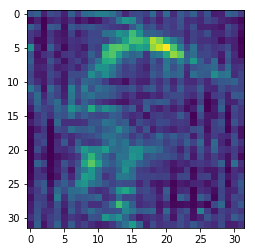

In [33]:
plt.imshow(pm.paint(state.X)[...].sum(axis=0))

In [34]:
astages = np.linspace(0.1, 1.0, 5, endpoint=True)
for action, ai, ac, af in leapfrog(astages):
    print(action, ai, ac, af)

F 0.1 0.1 0.1
K 0.1 0.1 0.18027756377319948
D 0.1 0.18027756377319948 0.325
F 0.1 0.325 0.325
K 0.18027756377319948 0.325 0.325
K 0.325 0.325 0.4227883631321941
D 0.325 0.4227883631321941 0.55
F 0.325 0.55 0.55
K 0.4227883631321941 0.55 0.55
K 0.55 0.55 0.6528782428600298
D 0.55 0.6528782428600298 0.775
F 0.55 0.775 0.775
K 0.6528782428600298 0.775 0.775
K 0.775 0.775 0.8803408430829505
D 0.775 0.8803408430829505 1.0
F 0.775 1.0 1.0
K 0.8803408430829505 1.0 1.0
